In [13]:
# Import libraries

from __future__ import print_function
import numpy as np
import zhinst.utils as ziut
import zhinst.core as zic
import os
import allantools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import time
import statistics as stat
import math
import os
import tempfile
import pickle
from matplotlib import font_manager

from itertools import chain


## Connect to the Zurich Instruments lock-in amplifer

In [14]:
device_id = "dev1592"
apilevel=1

(daq, device,dprops) = ziut.create_api_session(device_id, apilevel)
print(device)

KeyboardInterrupt: 

# Define all the measurement parameters of the Lock-in

In [ ]:
#define initial parameters

amplitude=0.1
rangeamp=1
out_channel = 0
out_mixer_channel = 0
in_channel = 0
demod_index = 0
osc_index = 0
time_constant = 5e-5
filterorder=4
frequency =  1.84410200e6
rate=1/(4*2*time_constant)

#set intial conditions for all the channels

ziut.disable_everything(daq, device_id)

exp_setting = [
        ["/%s/sigins/%d/ac" % (device_id, in_channel), 0],
        ["/%s/sigins/%d/diff" % (device_id, in_channel), 0],
        ["/%s/sigins/%d/imp50" % (device_id, in_channel), 0],
        ["/%s/sigins/%d/range" % (device_id, in_channel),1],
        ["/%s/demods/%d/enable" % (device_id, demod_index), 1],        
        ["/%s/demods/%d/adcselect" % (device_id, demod_index), in_channel],
        ["/%s/demods/%d/order" % (device_id, demod_index), filterorder],
        ["/%s/demods/%d/timeconstant" % (device_id, demod_index), time_constant],
        ["/%s/demods/%d/oscselect" % (device_id, demod_index), osc_index],
        ["/%s/demods/%d/harmonic" % (device_id, demod_index), 1],
        ["/%s/sigouts/%d/on" % (device_id, out_channel), 1],
       # ["/%s/sigouts/%d/enables/%d" % (device_id, out_channel, out_mixer_channel), 1],
        ["/%s/sigouts/%d/range" % (device_id, out_channel),rangeamp],
        ["/%s/oscs/%d/freq" % (device_id, osc_index), frequency],
       # ["/%s/sigouts/%d/amplitudes/%d" % (device_id, out_channel, out_mixer_channel),amplitude],
        ["/%s/demods/%d/rate" % (device_id,demod_index),rate],
    ]
daq.set(exp_setting)
daq.setInt('/%s/sigouts/0/on'%device_id, 1)

## Poll the data to start the measurements

In the next section the node is polled and the data is dumped in a temporary file to save memory allocations. For longer measurements its always advised to dump files in a temporary location rather than saving on to a single string.

In [ ]:
time_meas= 3 #Define the total measurement time in [s]

def L1_SimplePoll(device_id,apilevel,demod_index):
    apilevel_example=apilevel
    (daq, device,props) = ziut.create_api_session(device_id, apilevel_example)
    print(device)
    
    # Subscribe to the demodulator's sample node path.
    path = '/%s/demods/%d/sample' % (device, demod_index) # define the path where want to subscribe/measure

    # Poll the subscribed data from the data server. Poll will block and record
    # for poll_length seconds.
    total_length = time_meas # [s] # It will have to looped for the measurement
    poll_length = 1 # [s] # Poll length cannot be more than 5s
    poll_timeout = 500  # [ms]
    poll_flags = 0
    poll_return_flat_dict = True

    numbofPolls = int(np.ceil(total_length/poll_length))
    daq.subscribe(path) #subscribe to the path
    data_i = []
    ij=1
    for i_poll in range(numbofPolls):        
        data_i_poll = daq.poll(poll_length, poll_timeout, poll_flags, poll_return_flat_dict)        
        data_i_poll = data_i_poll[f'{path}']
        #data_i.append(data_i_poll)
        file = open("file_%s.dat" % ij,'wb')
        #print(ij)
        ij=ij+1
        pickle.dump(data_i_poll, file)
        file.close()

    daq.unsubscribe('*') #unsubscribe to all the paths. For a particular path use daq.unsubscribe(path)
    
    # get instrument's clockbase  
    clockbase = float(daq.getInt(f"/{device}/clockbase"))

    #return(data_i,clockbase)
    return(clockbase)

#Function to convert timestamp to real time

def timestamp_to_elapstime(timestamp, clockbase):
    timestamp = timestamp - timestamp[0]
    elapstime = timestamp/clockbase
    return(elapstime)

## Call the SimplePoll function to aquire

In [ ]:
# call the function to poll the data
#Data['raw'],clockbase = L1_SimplePoll(device_id,apilevel,demod_index)
clockbase=L1_SimplePoll(device_id,apilevel,demod_index)

print('Aquisition Complete')

Trying to connect to dev1592 on interface USB
Connected to dev1592 via data server 127.0.0.1:8005 and interface USB
dev1592
Aquisition Complete


# Combine the data into a single file

From the polled data we extract the relevant information. In this case the informations are the quadratures, frequencies and timestamps. End of the sectio the timestamps are converted into real time using the clockbase.

In [ ]:
now = datetime.date.today()  
ij=1

# Prepare the Data structure array to write the data

Data = {'frequency':[],'x':[],'y':[], 'elapsedtime':[]}

for ii in range(time_meas):
    #print(ij)
    file=open("file_%s.dat" % ij,'rb')
    data_i_poll = pickle.load(file)
    Data['elapsedtime'].append(data_i_poll['timestamp'])
    Data['frequency'].append(data_i_poll['frequency'])
    Data['x'].append(data_i_poll['x'])
    Data['y'].append(data_i_poll['y'])
    file.close()
    ij=ij+1

    
Data['elapsedtime']=np.array(list(chain.from_iterable(Data['elapsedtime'])))
Data['x']=np.array(list(chain.from_iterable(Data['x'])))
Data['y']=np.array(list(chain.from_iterable(Data['y'])))
Data['frequency']=np.array(list(chain.from_iterable(Data['frequency'])))

Data['elapsedtime'] = timestamp_to_elapstime(Data['elapsedtime'] , clockbase)
time0=Data['elapsedtime'][1]

# Plot the data

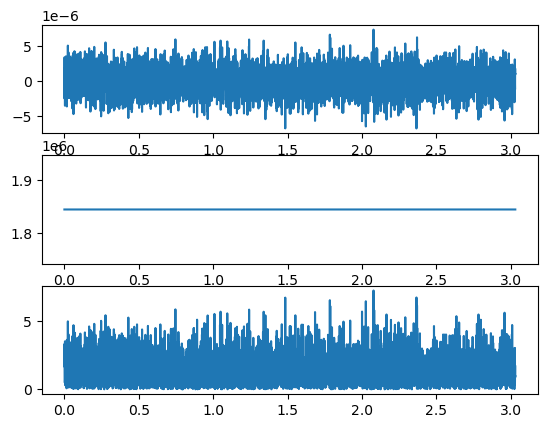

In [ ]:
# using a subplot structure for the plot

plt.subplot(3,1,1)
plt.plot(Data['elapsedtime'],np.arctan(Data['y'],Data['x']))
plt.subplot(3,1,2)
plt.plot(Data['elapsedtime'],Data['frequency'])
plt.subplot(3,1,3)
plt.plot(Data['elapsedtime'],np.sqrt(Data['x']**2+Data['y']**2)*0.7e6)
plt.show()

# Calculate sampling rate 

rate = Data['elapsedtime'][1:-1]-Data['elapsedtime'][0:-2] # not sure whats happening here
rate = np.round(1/rate[0]) #[Hz]   
Data['rate'] = rate

# Compute overlapping Allan Deviation 

In [ ]:
# Calculate Allan variance (ad is squared)

print('started to compute Allan variance')
taus = np.logspace(-1,time_meas,10000)
Data['phase']=np.arctan(Data['y'],Data['x'])

AllanFunction = 'allantools.oadev'   
(t2, ad, ade, adn) = allantools.oadev(Data['phase'],
                                      rate=Data['rate'], 
                                      data_type="phase",
                                      taus=taus,
                                      )
                                   

Data[AllanFunction]={'t2':t2,
                     'av':ad**2 ,
                     'ad':ad,                                   
                     'ade':ade,
                     'adn':adn,
                    }

print('fin')

started to compute Allan variance
fin


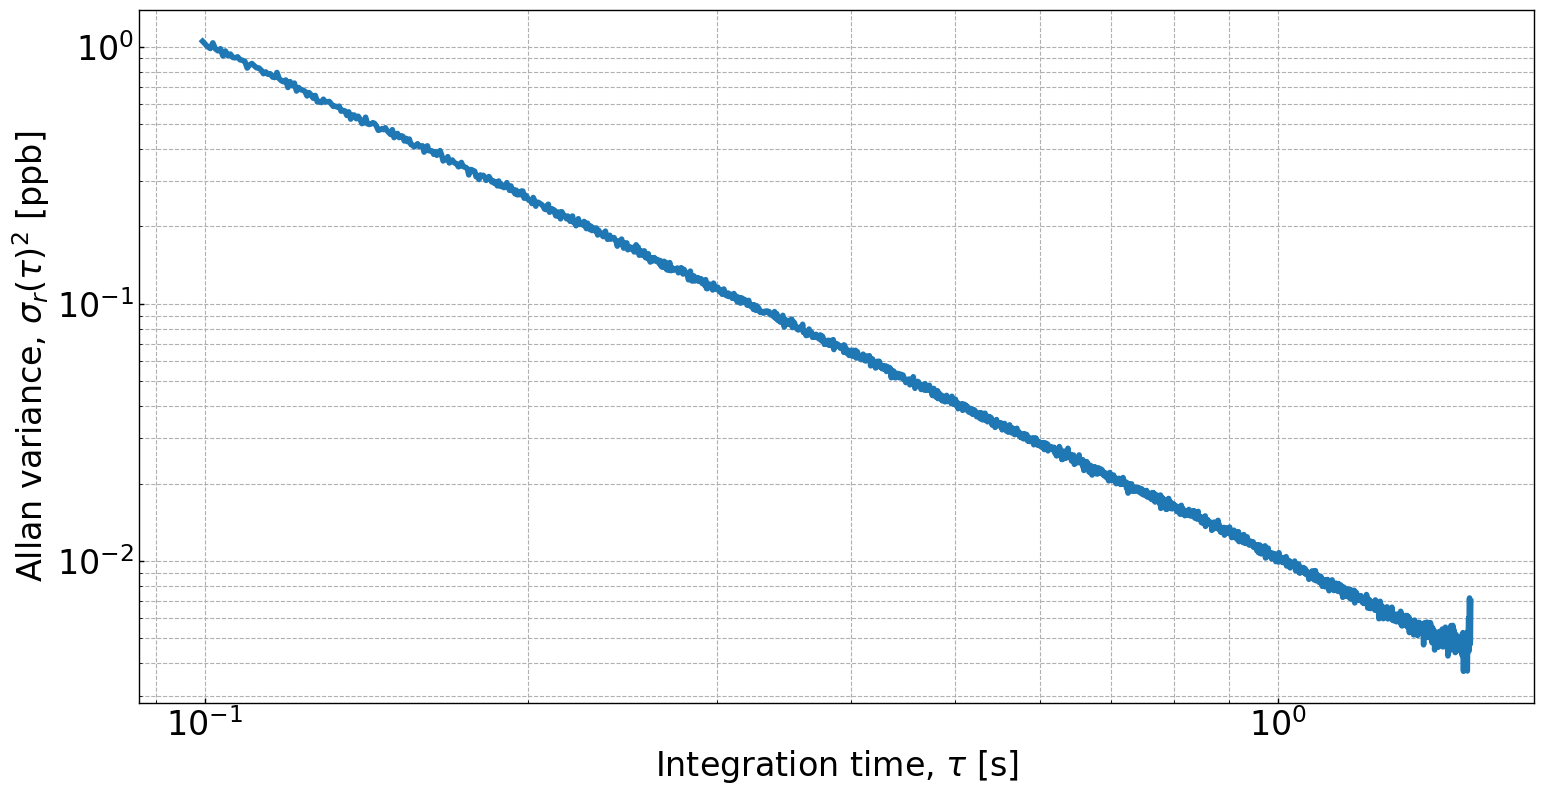

In [ ]:
#%% Plot the results
SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 24
params = {'font.size': SMALL_SIZE ,
          'axes.linewidth' : 1,
          'axes.titlesize': SMALL_SIZE,
          'axes.labelsize':MEDIUM_SIZE,
          
          "text.usetex": False,

          'legend.fontsize':SMALL_SIZE,
          
          'xtick.major.width' : 1,
          'xtick.labelsize' : SMALL_SIZE,
          'xtick.major.top': True,
          'xtick.minor.top': True,      
          'xtick.direction' :'in',
          
          'ytick.major.width': 1,
          'ytick.labelsize' : SMALL_SIZE,
          'ytick.major.right': True,
          'ytick.minor.right': True,
          'ytick.direction' :'in',
          
          'savefig.format' :'png',
          # 'figure.figsize' :(5,8.27)
          }
mpl.rcParams.update(params)

fig = plt.figure(figsize=[18,9]) 
ax = plt.axes()
ax.plot(Data[AllanFunction]['t2'],
        Data[AllanFunction]['av']*1e9,
        linewidth = 4,
        ) 
    

ax.set_xscale("log")
ax.set_yscale("log")
#ax.legend()
ax.set_xlabel(r'Integration time, $\tau$ [s]')
ax.set_ylabel(r'Allan variance, $\sigma_r(\tau)^2$ [ppb]')
ax.axes.grid(which='both',
             linestyle = '--' )
ax.axes.tick_params(which='both')
#ax.set_title('Frequency stability, 17 kHz, PLL bandwidth ~ 300 Hz')
          
plt.show()



# Saving the data

In [ ]:
#Create a directory with todays date

os.chdir('C:\\Users\\avishekc\\OneDrive - Zurich Instruments AG\\Documents\\Zurich Instruments\\Meas Data\\Allan_Deviation')
now = datetime.date.today()  
todaystr = now.isoformat()  
os.mkdir(todaystr)

In [ ]:
#Change the directory to todays direcrtory and save the figure with proper name

os.chdir(f'C:\\Users\\avishekc\\OneDrive - Zurich Instruments AG\\Documents\\Zurich Instruments\\Meas Data\\Allan_Deviation\\{todaystr}')

t = time.localtime()
current_time = time.strftime("%H_%M", t)

file=open(f'Allan_Variance_{current_time}.dat',"w")

np.savetxt(file, np.array([Data['elapsedtime'],Data['frequency'],Data['x'], Data['y']]).T, fmt="%1.10e", delimiter="\t")



# Importing the data and plot

In [ ]:
os.chdir('C:\\Users\\avishekc\\OneDrive - Zurich Instruments AG\\Documents\\Zurich Instruments\\Meas Data\\Allan_Deviation\\2023-07-12')

file1=np.loadtxt('Allan_Variance_No_PLL.dat',delimiter="\t")
file2=np.loadtxt('Allan_Variance_PLL_20Hz.dat',delimiter="\t")
file3=np.loadtxt('Allan_Variance_PLL_200Hz.dat',delimiter="\t")
file4=np.loadtxt('Allan_Variance_13_58.dat',delimiter="\t")

Data1={'time':[],'freq':[],'x':[],'y':[]}
Data2={'time':[],'freq':[],'x':[],'y':[]}
Data3={'time':[],'freq':[],'x':[],'y':[]}
Data4={'time':[],'freq':[],'x':[],'y':[]}

Data1['time']=file1[:,0]
Data1['freq']=file1[:,1]
Data1['x']=file1[:,2]
Data1['y']=file1[:,3]

Data2['time']=file2[:,0]
Data2['freq']=file2[:,1]
Data2['x']=file2[:,2]
Data2['y']=file2[:,3]

Data3['time']=file3[:,0]
Data3['freq']=file3[:,1]
Data3['x']=file3[:,2]
Data3['y']=file3[:,3]

Data4['time']=file4[:,0]
Data4['freq']=file4[:,1]
Data4['x']=file4[:,2]
Data4['y']=file4[:,3]

rate1 = Data1['time'][1:-1]-Data1['time'][0:-2] # not sure whats happening here
rate1= np.round(1/rate1[0]) #[Hz] 
Data1['rate']=rate1

rate2 = Data2['time'][1:-1]-Data2['time'][0:-2] # not sure whats happening here
rate2= np.round(1/rate2[0]) #[Hz] 
Data2['rate']=rate2

rate3 = Data3['time'][1:-1]-Data3['time'][0:-2] # not sure whats happening here
rate3= np.round(1/rate3[0]) #[Hz] 
Data3['rate']=rate3

rate4 = Data4['time'][1:-1]-Data4['time'][0:-2] # not sure whats happening here
rate4= np.round(1/rate4[0]) #[Hz] 
Data4['rate']=rate4

In [ ]:
init=-1
#Data set 1
time0=Data1['time'][1]
time_meas=Data1['time'][-1]


taus = np.logspace(init,time_meas,10000)
Data1['theta']=np.arctan(Data1['y'],Data1['x'])

AllanFunction = 'allantools.oadev'   
(t21, ad1, ade1, adn1) = allantools.oadev(Data1['theta'],
                                      rate=Data1['rate'], 
                                      data_type="phase",
                                      taus=taus,
                                      )
                                   

Data1[AllanFunction]={'t2':t21,
                     'av':ad1**2,
                     'ad':ad1,                                   
                     'ade':ade1,
                     'adn':adn1,
                    }

#Data set 2

time0=Data2['time'][1]
time_meas=Data2['time'][-1]


taus = np.logspace(init,time_meas,10000)
Data2['theta']=np.arctan(Data2['y'],Data2['x'])

AllanFunction = 'allantools.oadev'   
(t22, ad2, ade2, adn2) = allantools.oadev(Data2['theta'],
                                      rate=Data2['rate'], 
                                      data_type="phase",
                                      taus=taus,
                                      )
                                   

Data2[AllanFunction]={'t2':t22,
                     'av':ad2**2,
                     'ad':ad2,                                   
                     'ade':ade2,
                     'adn':adn2,
                    }

#Data set 3

time0=Data3['time'][1]
time_meas=Data3['time'][-1]


taus = np.logspace(init,time_meas,10000)
Data3['theta']=np.arctan(Data3['y'],Data3['x'])

AllanFunction = 'allantools.oadev'   
(t23, ad3, ade3, adn3) = allantools.oadev(Data3['theta'],
                                      rate=Data3['rate'], 
                                      data_type="phase",
                                      taus=taus,
                                      )
                                   

Data3[AllanFunction]={'t2':t23,
                     'av':ad3**2,
                     'ad':ad3,                                   
                     'ade':ade3,
                     'adn':adn3,
                    }


# #Data set 4

time0=Data4['time'][1]
time_meas=Data4['time'][-1]


taus = np.logspace(init,time_meas,10000)
Data4['theta']=np.arctan(Data4['y'],Data4['x'])

AllanFunction = 'allantools.oadev'   
(t24, ad4, ade4, adn4) = allantools.oadev(Data4['theta'],
                                      rate=Data4['rate'], 
                                      data_type="phase",
                                      taus=taus,
                                      )
                                   

Data4[AllanFunction]={'t2':t24,
                     'av':ad4**2,
                     'ad':ad4,                                   
                     'ade':ade4,
                     'adn':adn4,
                    }

# Example of Multiplots

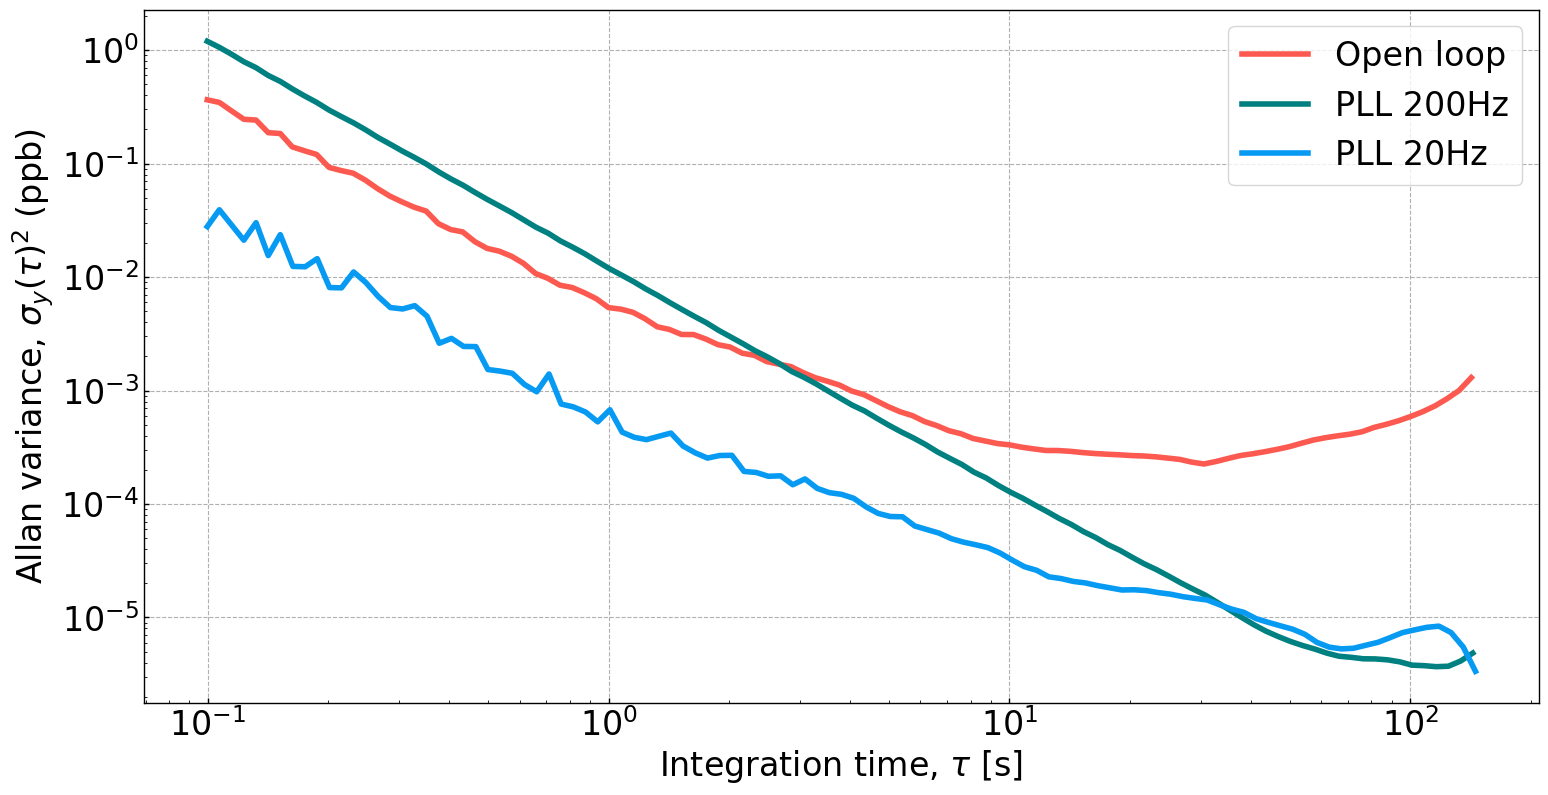

In [ ]:
#%% Plot the results

SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 24
params = {'font.size': SMALL_SIZE ,
          'axes.linewidth' : 1,
          'axes.titlesize': SMALL_SIZE,
          'axes.labelsize':MEDIUM_SIZE,
          
          "text.usetex": False,

          'legend.fontsize':SMALL_SIZE,
          
          'xtick.major.width' : 1,
          'xtick.labelsize' : SMALL_SIZE,
          'xtick.major.top': True,
          'xtick.minor.top': True,          
          'xtick.direction' :'in',
          
          'ytick.major.width': 1, 
          'ytick.labelsize' : SMALL_SIZE,
          'ytick.major.right': True,
          'ytick.minor.right': True,
          'ytick.direction' :'in',
          
          'savefig.format' :'png',
          # 'figure.figsize' :(5,8.27)
          }
mpl.rcParams.update(params)

fig = plt.figure(figsize=[18,9]) 
ax = plt.axes()
ax.plot(Data1[AllanFunction]['t2'],
        Data1[AllanFunction]['av']*1e9,
        linewidth = 4,
        color='#FC5A50'
        ) 

ax.plot(Data3[AllanFunction]['t2'],
       Data3[AllanFunction]['av']*1e9,
       linewidth = 4,
       color='#008080'        
       )        

ax.plot(Data2[AllanFunction]['t2'],
        Data2[AllanFunction]['av']*1e9,
        linewidth = 4,
        color='#069AF3'        
        )



# ax.plot(Data4[AllanFunction]['t2'],
#         Data4[AllanFunction]['av']*1e9,
#         linewidth = 4,        
#         )


ax.legend(['Open loop', 'PLL 200Hz','PLL 20Hz'])

ax.set_xscale("log")
ax.set_yscale("log")
#ax.legend()
ax.set_xlabel(r'Integration time, $\tau$ [s]')
ax.set_ylabel(r'Allan variance, $\sigma_y(\tau)^2$ (ppb)')
ax.axes.grid(which='major',
             linestyle = '--' )
ax.axes.tick_params(which='both')
#ax.set_title('Frequency stability, 17 kHz, PLL bandwidth ~ 300 Hz')
#plt.title('Allan Deviation with Locking bw_10kHz')

plt.savefig('AllanDev.pdf',dpi='figure')

plt.show()

In [ ]:
font_manager.findSystemFonts(fontpaths=None, fontext="otf")


['C:\\Windows\\Fonts\\COOPBL.TTF',
 'C:\\Windows\\Fonts\\NirmalaS.ttf',
 'C:\\Windows\\Fonts\\palabi.ttf',
 'C:\\Windows\\Fonts\\GOTHICBI.TTF',
 'C:\\Windows\\Fonts\\ARIALNI.TTF',
 'C:\\Windows\\Fonts\\mmrtextb.ttf',
 'C:\\Windows\\Fonts\\CALIFI.TTF',
 'C:\\Windows\\Fonts\\BSSYM7.TTF',
 'C:\\Windows\\Fonts\\FTLTLT.TTF',
 'C:\\Windows\\Fonts\\ERASMD.TTF',
 'C:\\Windows\\Fonts\\AGENCYR.TTF',
 'C:\\Windows\\Fonts\\timesbi.ttf',
 'C:\\Windows\\Fonts\\LFAXI.TTF',
 'C:\\Windows\\Fonts\\PALSCRI.TTF',
 'C:\\Windows\\Fonts\\ebrimabd.ttf',
 'C:\\Windows\\Fonts\\CENTAUR.TTF',
 'C:\\Windows\\Fonts\\ALGER.TTF',
 'C:\\Windows\\Fonts\\LSANSDI.TTF',
 'C:\\Windows\\Fonts\\GOTHIC.TTF',
 'C:\\Windows\\Fonts\\holomdl2.ttf',
 'C:\\Windows\\Fonts\\LSANSD.TTF',
 'C:\\Windows\\Fonts\\HARNGTON.TTF',
 'C:\\Windows\\Fonts\\tahoma.ttf',
 'C:\\Windows\\Fonts\\timesi.ttf',
 'C:\\Windows\\Fonts\\NIAGENG.TTF',
 'C:\\Windows\\Fonts\\georgiab.ttf',
 'C:\\Windows\\Fonts\\ROCC____.TTF',
 'C:\\Windows\\Fonts\\javatext.ttf

In [ ]:
font_manager.findfont("STIXGeneralBolIta")

findfont: Font family ['STIXGeneralBolIta'] not found. Falling back to DejaVu Sans.


'C:\\Users\\avishekc\\AppData\\Local\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'

In [ ]:
import shutil
import matplotlib

shutil.rmtree(matplotlib.get_cachedir())

In [ ]:
matplotlib.font_manager._load_fontmanager(try_read_cache=False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\avishekc\\.matplotlib\\fontlist-v330.json.matplotlib-lock'